In [1]:
# Cell 2: Imports
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm
from transformers import TrainerCallback

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/tahlilmahfuz/RAG_Implementation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Cell 3: Load and inspect data
df = pd.read_csv('3.robertaXL.csv')

# Keep only relevant columns
df = df[['Review', 'Sentiment']]

# Data checks
print("\nFirst 5 reviews:")
print(df['Review'].head())
print("\nLabel distribution:")
print(df['Sentiment'].value_counts(normalize=True))
print("\nMissing values:", df.isnull().sum())


First 5 reviews:
0    Alhamdulillah.. the best al quran application,...
1    the best quraan app you can find. it literally...
2                                         Very helpful
3    The recent edition does explain the source of ...
4                 May Allah reward you richly rewarded
Name: Review, dtype: object

Label distribution:
Sentiment
positive    0.894238
neutral     0.058884
negative    0.046878
Name: proportion, dtype: float64

Missing values: Review       0
Sentiment    0
dtype: int64


In [3]:
#  Cell 4: Preprocessing
# Create labels
sentiment_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label'] = df['Sentiment'].map(sentiment_map)

# Clean text data
def clean_text(text):
    return text.strip()  # Add any additional cleaning steps here

df['text'] = df['Review'].apply(clean_text)

# Cell 5: Train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Convert to Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])


In [4]:
# New Cell: Class Weight Calculation (Add this BEFORE Cell 6)
# -----------------------------------------------------------
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("Training Class Distribution:")
print(train_df['label'].value_counts())

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"\nClass Weights: {class_weights}")

Training Class Distribution:
label
0    50407
1     3319
2     2642
Name: count, dtype: int64

Class Weights: tensor([0.3728, 5.6611, 7.1118], device='cuda:0')


In [5]:
# Cell 6: Model and tokenizer
model_name = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: 'positive', 1: 'neutral', 2: 'negative'}
).to(device)
model.classifier.weight = torch.nn.Parameter(class_weights) 

In [6]:
# Cell 7: Tokenization
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=128,
        padding='max_length'
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 14092/14092 [00:00<00:00, 38646.74 examples/s]


In [7]:
class TqdmProgressCallback(TrainerCallback):
    def __init__(self):
        self.progress_bar = None
        self.epoch_bar = None
        self.current_epoch = 0
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.total_epochs = int(args.num_train_epochs)
        self.total_steps = state.max_steps
        self.progress_bar = tqdm(total=self.total_steps, desc="Total Progress")
        
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.current_epoch += 1
        steps_per_epoch = len(train_dataset) // (args.per_device_train_batch_size * args.gradient_accumulation_steps)
        self.epoch_bar = tqdm(total=steps_per_epoch, 
                            desc=f"Epoch {self.current_epoch}/{self.total_epochs}",
                            leave=False)
        
    def on_step_end(self, args, state, control, **kwargs):
        # Safely get latest metrics
        metrics = {}
        if state.log_history:
            last_log = state.log_history[-1]
            metrics = {
                'loss': last_log.get('loss', last_log.get('eval_loss', 'N/A')),
                'acc': last_log.get('eval_accuracy', 'N/A')
            }
        
        # Update progress bars
        if self.progress_bar.n < self.total_steps:
            self.progress_bar.update(1)
            self.progress_bar.set_postfix(metrics)
        
        if self.epoch_bar.n < self.epoch_bar.total:
            self.epoch_bar.update(1)
            self.epoch_bar.set_postfix(metrics)
        
    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_bar:
            self.epoch_bar.close()
        
    def on_train_end(self, args, state, control, **kwargs):
        if self.progress_bar:
            self.progress_bar.close()
        if self.epoch_bar:
            self.epoch_bar.close()

In [8]:
# Cell 8: Training setup
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    gradient_accumulation_steps=2,
    report_to="none",
    disable_tqdm=False,
    gradient_checkpointing=True,  # Add memory optimization
    optim="adamw_torch",  # Explicit optimizer
    lr_scheduler_type="cosine",  # Better learning schedule
    max_grad_norm=1.0  # Gradient clipping
)

In [9]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    # Add zero_division parameter
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        # EarlyStoppingCallback(early_stopping_patience=5),
        TqdmProgressCallback()
    ]
)


In [10]:
# Cell 9: Training
print("Starting training...")
trainer.train()

Starting training...


Total Progress:   0%|          | 1/5283 [00:00<19:02,  4.62it/s]

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.104000,0.129610,0.966506,0.965140,0.964720,0.966506
1000,0.079900,0.083477,0.976653,0.976476,0.976610,0.976653
1500,0.075000,0.072011,0.980485,0.980398,0.980546,0.980485
2000,0.047000,0.060763,0.984601,0.984319,0.984374,0.984601
2500,0.046200,0.046513,0.988362,0.988280,0.988279,0.988362
3000,0.023900,0.044151,0.989994,0.989993,0.990019,0.989994
3500,0.019300,0.041907,0.991414,0.991356,0.991329,0.991414
4000,0.022100,0.038920,0.992265,0.992268,0.992302,0.992265
4500,0.013700,0.041423,0.991910,0.991872,0.991885,0.991910
5000,0.008400,0.040234,0.991555,0.991524,0.991513,0.991555


Total Progress: 100%|██████████| 5283/5283 [13:24<00:00,  6.56it/s, loss=0.0109, acc=N/A]    


TrainOutput(global_step=5283, training_loss=0.07416251459718315, metrics={'train_runtime': 804.8763, 'train_samples_per_second': 210.099, 'train_steps_per_second': 6.564, 'total_flos': 1.1118120968945664e+16, 'train_loss': 0.07416251459718315, 'epoch': 2.9985807550383194})

In [11]:
# Cell 10: Evaluation
final_metrics = trainer.evaluate()
print(f"\nFinal Validation Accuracy: {final_metrics['eval_accuracy']:.4f}")
print(f"Final Validation F1 Score: {final_metrics['eval_f1']:.4f}")



Final Validation Accuracy: 0.9923
Final Validation F1 Score: 0.9923


Classification Report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00     12601
     neutral       0.97      0.94      0.95       830
    negative       0.94      0.97      0.95       661

    accuracy                           0.99     14092
   macro avg       0.97      0.97      0.97     14092
weighted avg       0.99      0.99      0.99     14092



<Figure size 1000x800 with 0 Axes>

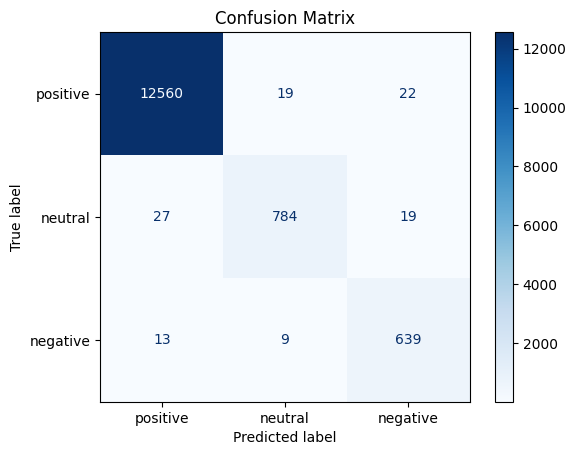

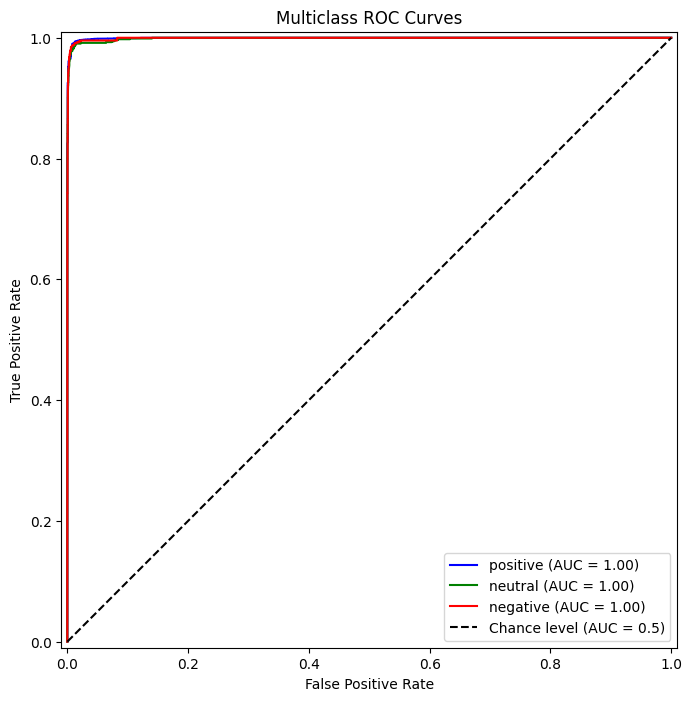


AUC Scores:
positive: 0.9993
neutral: 0.9988
negative: 0.9992
Micro-average: 0.9997


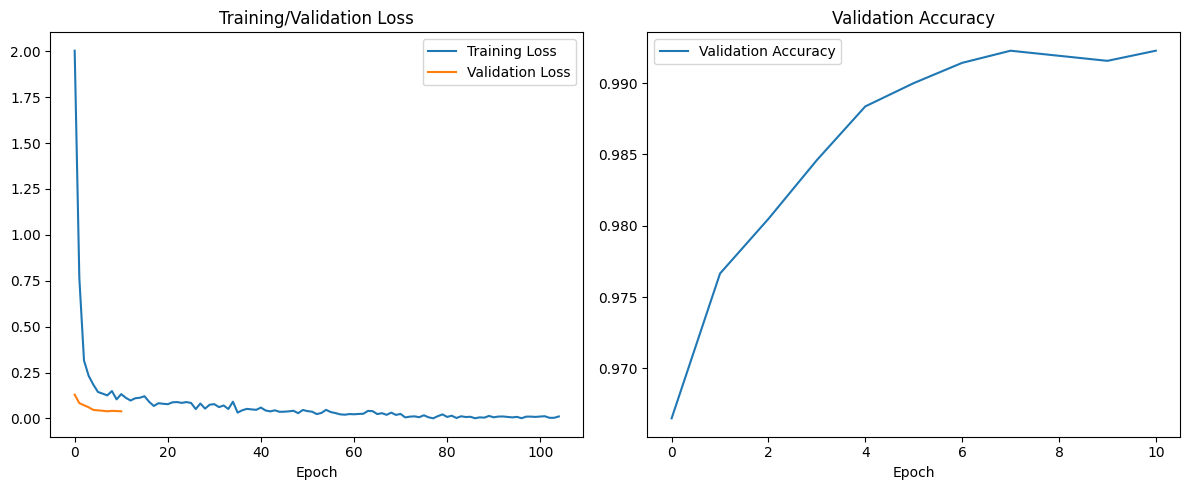

In [12]:
# Cell X: Evaluation (Add this after training cell)
# =================================================
def evaluate_model(trainer, val_dataset, class_names):
    # Get predictions
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1).numpy()
    y_true = predictions.label_ids

    # 1. Classification Report
    print("Classification Report:")
    print(classification_report(y_true, preds, target_names=class_names))

    # 2. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # 3. ROC Curve and AUC Scores
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'orange']
    for i, color, class_name in zip(range(n_classes), colors, class_names):
        RocCurveDisplay(
            fpr=fpr[i],
            tpr=tpr[i],
            roc_auc=roc_auc[i],
            estimator_name=class_name
        ).plot(ax=plt.gca(), color=color)

    plt.plot([0, 1], [0, 1], 'k--', label="Chance level (AUC = 0.5)")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Print AUC Scores
    print("\nAUC Scores:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {roc_auc[i]:.4f}")
    print(f"Micro-average: {roc_auc['micro']:.4f}")

    # 5. Additional Metrics Visualization
    plt.figure(figsize=(12, 5))
    
    # Training History Metrics
    history = trainer.state.log_history
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(eval_loss, label='Validation Loss')
    plt.title('Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(eval_acc, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run evaluation
class_names = ['positive', 'neutral', 'negative']
evaluate_model(trainer, val_dataset, class_names)

In [13]:
# Cell 11: Save model
trainer.save_model('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')
print("Model saved successfully!")

Model saved successfully!


In [14]:
# Cell 12: Prediction Example (You can use this later)
def predict_sentiment(text):
    inputs = tokenizer(
        text,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs).item()
    
    return {
        'text': text,
        'sentiment': model.config.id2label[pred_label],
        'probabilities': {
            'positive': probs[0][0].item(),
            'neutral': probs[0][1].item(),
            'negative': probs[0][2].item()
        }
    }

In [16]:
# Example usage:
test_review = "SubhanAllah, this is a great product!"
result = predict_sentiment(test_review)
print("\nPrediction Example:")
print(f"Review: {result['text']}")
print(f"Predicted Sentiment: {result['sentiment']}")
print(f"Probabilities: {result['probabilities']}")


Prediction Example:
Review: SubhanAllah, this is a great product!
Predicted Sentiment: positive
Probabilities: {'positive': 0.9999668598175049, 'neutral': 1.253303616977064e-05, 'negative': 2.066348315565847e-05}
